In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys


In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad
import torch
import torch.nn as nn
import torch.nn.functional as F
from model import DUSTED
import squidpy as sq
import os
import matplotlib.pyplot as plt
from trainer import train_GAE
import scipy.sparse as sp
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from STAGATE_pyG.utils import Transfer_pytorch_Data, mclust_R
from tqdm import tqdm
from loss import NB_loss,ZINB_loss
import STAGATE_pyG as STAGATE
from STAGATE_pyG.Train_STAGATE import train_STAGATE
import STAGATE_pyG as STAGATE
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score


In [3]:
section_id = '151673'
input_dir = os.path.join('/databak/liyifu/Final_Project/data/DLPFC', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:,adata.var['total_counts']>100]

In [4]:
adata

View of AnnData object with n_obs × n_vars = 3639 × 11353
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
sc.pp.highly_variable_genes(adata,n_top_genes=3000,flavor="seurat_v3")
hvg = list(adata[:,adata.var['highly_variable']].var_names)
select_genes = list(set(hvg))
adata = adata[:,select_genes]
scale_factor = adata.obs.total_counts/np.median(adata.obs.total_counts)
adata.obs['scale_factor'] = scale_factor
adata.raw = adata.copy()
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

In [6]:
from openpyxl import load_workbook


workbook = load_workbook('/databak/liyifu/Final_Project/data/DLPFC/41593_2020_787_MOESM3_ESM.xlsx')
sheet = workbook.active
column_data = [cell.value for cell in sheet['E'] if cell.value is not None]
column_data = column_data[1:]
#print(column_data)

In [9]:
adata.layers['Raw'] = adata.X

------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.


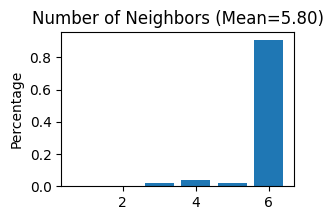

In [12]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

Size of Input:  (3639, 3000)


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.67it/s]


min_loss: 0.5375023484230042


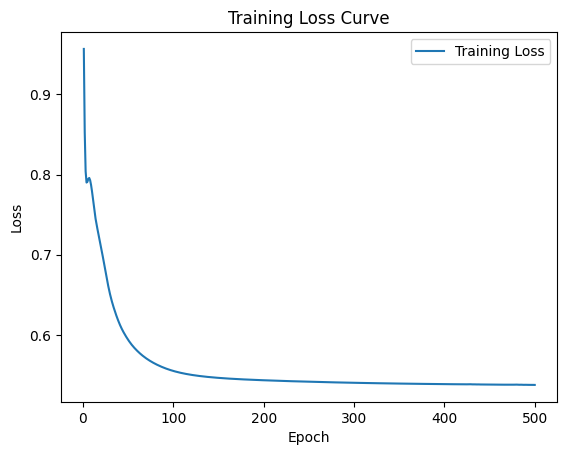

True
zinb


In [18]:
model = DUSTED([adata.X.shape[1], 512,30])
adata = train_GAE(adata, model, save_reconstrction=True, key_added='DUSTED', loss_mode='zinb',lr=0.0001,n_epochs=500)
sc.pp.normalize_total(adata,layer='DUSTED',target_sum=1e4)
sc.pp.log1p(adata,layer='DUSTED')

In [19]:
# read the annotation
Ann_df = pd.read_csv(os.path.join(input_dir, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata = adata[adata.obs['Ground Truth']!='nan',]
plt.rcParams["figure.figsize"] = (3, 3)

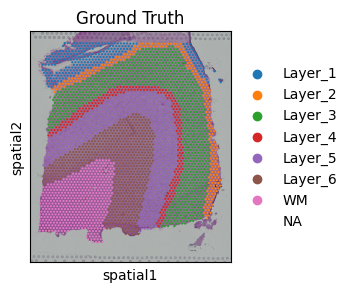

In [20]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

In [22]:
adata = adata[adata.obs['Ground Truth']!='NA']

In [23]:
# Get spatial coordinates
spatial_coords = adata.obsm['spatial'].toarray()

# Reverse the y-coordinate to flip the plot vertically
spatial_coords[:, 1] = np.max(spatial_coords[:, 1]) - spatial_coords[:, 1]

# Update spatial coordinates in AnnData object
adata.obsm['spatial'] = spatial_coords#.toarray()
adata.obsm['spatial']

array([[9791, 3116],
       [5769, 8777],
       [4068, 2079],
       ...,
       [4631, 3753],
       [5571,  391],
       [6317, 8293]])

In [24]:
def cluster(adata, layer_key='raw', n_epochs=500, threshold=1.0):
    cdata = ad.AnnData(X=adata.layers[layer_key], obs=adata.obs, var=adata.var, obsm=adata.obsm)
    
    STAGATE.Cal_Spatial_Net(cdata, rad_cutoff=150)
    STAGATE.Stats_Spatial_Net(cdata)
    
    cdata = train_STAGATE(cdata, n_epochs=n_epochs, lr=0.0005)
    sc.pp.neighbors(cdata, use_rep='STAGATE')
    sc.tl.umap(cdata)
    adata = STAGATE.mclust_R(cdata, used_obsm='STAGATE', num_cluster=7)
    
    obs_df = cdata.obs.dropna()
    ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
    NMI = normalized_mutual_info_score(obs_df['mclust'], obs_df['Ground Truth'])
    homogeneity = homogeneity_score(obs_df['mclust'], obs_df['Ground Truth'])
    
    print('Adjusted Rand index = %.2f' % ARI)
    print('Normalized Mutual Information = %.2f' % NMI)
    print('Homogeneity Score = %.2f' % homogeneity)
    
    plt.rcParams["figure.figsize"] = (3, 3)
    sc.pl.umap(cdata, color=["mclust", "Ground Truth"], title=[layer_key, "Ground Truth"])

    
    plt.rcParams["figure.figsize"] = (3, 3)

    sc.pl.embedding(cdata, basis="spatial", color=["mclust", "Ground Truth"], title=[layer_key, "Ground Truth"])


------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
Size of Input:  (3639, 3000)


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.89it/s]
2024-05-05 08:34:01.259448: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 08:34:01.259955: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 08:34:01.264431: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 08:34:01.307271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild 

fitting ...
  |======================================================================| 100%
Adjusted Rand index = 0.60
Normalized Mutual Information = 0.73
Homogeneity Score = 0.71


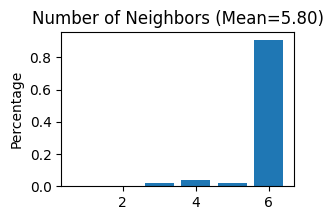

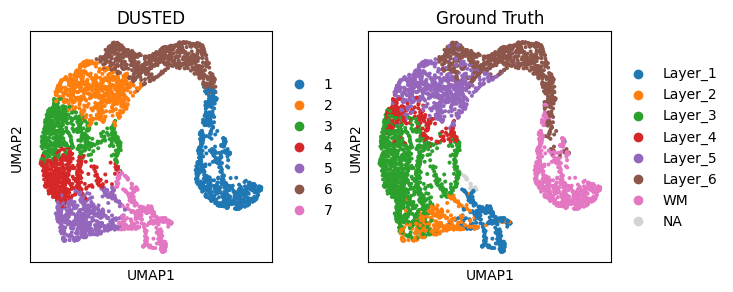

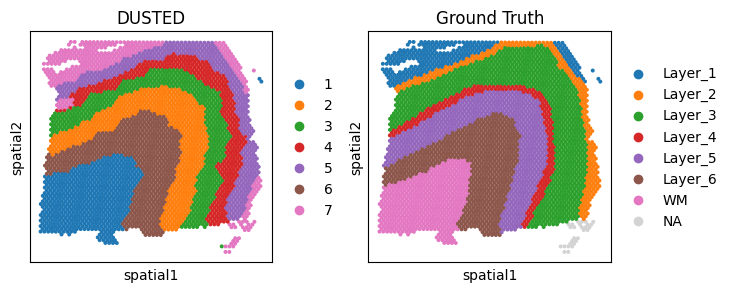

In [25]:
cluster(adata,layer_key = 'DUSTED')